In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats


Read Data

In [2]:
data = pd.read_excel("Load_Data_in_kW.xlsx",header=None)
data.head()

,0
0,5551.82208
1,4983.17184
2,4888.39680
3,5072.95872
4,5196.25980


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2184 non-null   float64
dtypes: float64(1)
memory usage: 17.2 KB


Outliers

In [4]:
z = np.abs(stats.zscore(data))
print(z)

[[0.04910416]
 [0.08229029]
 [0.08782131]
 ...
 [0.09743692]
 [0.07253822]
 [0.03181432]]


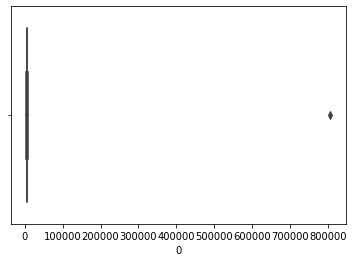

In [5]:
sns.boxplot(x=data[0])

In [6]:
df = data
q = df[0].quantile(0.99)
df[df[0] < q]
q_low = df[0].quantile(0.01)
q_hi  = df[0].quantile(0.99)

df_filtered = df[(df[0] < q_hi) & (df[0] > q_low)]
df_filtered.head()

,0
0,5551.82208
1,4983.17184
2,4888.39680
3,5072.95872
4,5196.25980


In [7]:
print(len(data))
print(len(df_filtered))
if(len(data) == len(df_filtered)):
    print('No outliners')


2184
2140


 Normalisation

In [8]:
data = df_filtered
data_n = data.copy()
data_n = (data_n - data_n.min())/(data_n.max() - data_n.min())
data_n.head()

,0
0,0.372950
1,0.254941
2,0.235273
3,0.273574
4,0.299162


Split Data

In [9]:
train_data,test_data = train_test_split(data_n,test_size=0.1)

In [10]:
print(len(train_data))
train_data.head()

1926


,0
1028,0.311358
408,0.420115
1209,0.363245
1286,0.726426
587,0.597904


In [11]:
xa = []
ya = []
for i in range(len(train_data.iloc[:,0])-24):
    xa.append(train_data.iloc[i,0])
    ya.append(train_data.iloc[i+24,0])

Train Data

In [12]:
from sympy import Symbol, Derivative, symbols
m= Symbol('m')
c= Symbol('c')
function = '0.5*(y-m*x-c)**2'
partialderiv= Derivative(function, m)
dfm = partialderiv.doit()
partialderiv= Derivative(function, c)
dfc = partialderiv.doit()
err = []
print(f'first order derivatives of given function are de/dm = {dfm} ,de/dc = {dfc}')

#step 1 initialise values 
m1 = 1.0 
c1 = -1.0  #variable x, y
itr = 20  #epoches
GM = 0
GC = 0
ep = 10**(-8)
learning_rate = 0.1  #learning rate
for i in range(0,itr):
    er = 0
    for j in range(0,len(xa)):
        er +=  ((ya[j] - (m1 * xa[j]) - c1))**2
        #step 2 substitute x ,y in first order derivatives df/dx, df/dy
        m = symbols('m')
        c = symbols('c')
        x = symbols('x')
        y = symbols('y')
        dfmv = dfm.subs(m, m1) 
        dfmv = dfmv.subs(c, c1) 
        dfmv = dfmv.subs(x, xa[j]) 
        dfmv = dfmv.subs(y, ya[j]) 
        dfmv = round(dfmv,2)
        dfcv = dfc.subs(c, c1) 
        dfcv = dfcv.subs(m, m1) 
        dfcv = dfcv.subs(x, xa[j]) 
        dfcv = dfcv.subs(y, ya[j]) 
        dfcv = round(dfcv,2)
        GM = GM + (dfmv**2)
        GC = GC + (dfcv**2)
        #step3 find change in x , y
        dm = (-1.0)*(learning_rate/(GM+ep)**(0.5))*dfmv
        dc = (-1.0)*(learning_rate/(GC+ep)**(0.5))*dfcv
        #step4 update variable 
        m1 = m1 + dm
        m1 = round(m1, 2) 
        c1 = c1 + dc
        c1 = round(c1, 2)
        
        er = (1/(2*len(xa)))*(er)
        err.append(er)
    #step5 increment iterations 
    #step6 break loop if iterations exceed no of epoches
#step7 print variable x1, y1
print(m1, c1)
print(f'minimum value obtained at m = {m1} ,c ={c1} for given function')

first order derivatives of given function are de/dm = -1.0*x*(-c - m*x + y) ,de/dc = 1.0*c + 1.0*m*x - 1.0*y
0.19 0.30
minimum value obtained at m = 0.19 ,c =0.30 for given function


RMSE for Training data

In [13]:

train_data_pred = [i for i in xa]
for k in range(len(xa)):
    train_data_pred[k]=(m1*xa[k] + c1)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ya,train_data_pred)
mse


0.052807882245338986

Text(0.5, 1.0, 'predicted data vs actual data')

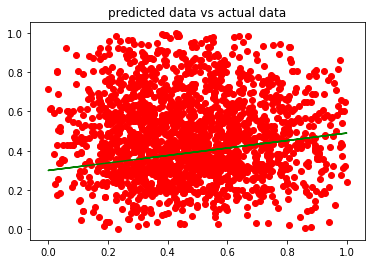

In [14]:
plt.plot(np.array(xa),np.array(train_data_pred),'green')
plt.scatter(np.array(xa),np.array(ya),color='red')
plt.title('predicted data vs actual data')

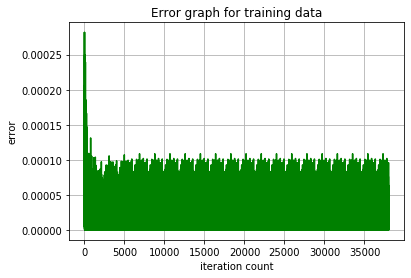

In [15]:
iters = np.arange(itr*len(xa))
plt.plot(iters,err,'green')
plt.title("Error graph for training data")
plt.xlabel("iteration count")
plt.ylabel("error")
plt.grid()

Test Data

In [16]:
xa = []
ya = []
for i in range(len(test_data.iloc[:,0])-24):
    xa.append(test_data.iloc[i,0])
    ya.append(test_data.iloc[i+24,0])
test_data_pred = [i for i in xa]
for k in range(len(xa)):
    test_data_pred[k]=(m1*xa[k] + c1)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ya,test_data_pred)
mse

0.05083028417737184

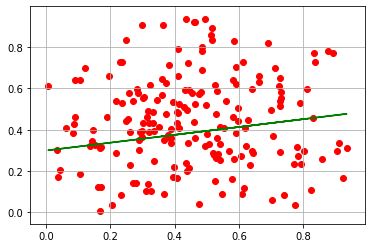

In [17]:
plt.scatter(xa,ya,color='red')
plt.plot(xa,test_data_pred,'green')
plt.grid()

Predict Output

In [18]:
x_max = y_max= 8841.669480
x_min = y_min = 3377.919600
x =x1 = float(input("enter load of previous hour :"))
x = (x - x_min)/(x_max - x_min)
y = m1*x + c1
y = y*(y_max - y_min) + y_min
print(f"load at hour based on its previous hour is : {y}")

enter load of previous hour :5073
load at hour based on its previous hour is : 5337.94338023438
